In [1]:
import torch
import os
import pandas as pd
from torchvision.io import read_image
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
labels_map = {
    0: "T Shirt",
    1: "Trousers",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",}
# figure = plt.figure(figsize = (8,8))
# cols, rows = 3,3
# for i in range(1, cols* rows + 1):
#     sample_idx = torch.randint(len(training_data), size =(1,)).item()
#     img, label = training_data[sample_idx]
#     figure.add_subplot(rows,cols,i)
#     plt.title(labels_map[label])
#     plt.axis("off")
#     plt.imshow(img.squeeze(),cmap = "gray")
# plt.show()  


In [4]:
class CustomImageDataset():
    def __init__(self, annotations_file, img_dir, transform=None,target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
         return len(self.img_labels)
       
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx,1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image,label                

In [5]:
batch_size = 5

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data,batch_size=batch_size)
for x,y in test_dataloader:
    print(f"shape of X[N,C,H,W]: {x.shape}")
    print(f"Shape of y:{y.shape}{y.dtype}")
    print(f"Labels:{y.numpy()}")
    break

shape of X[N,C,H,W]: torch.Size([5, 1, 28, 28])
Shape of y:torch.Size([5])torch.int64
Labels:[9 2 1 1 6]


Feature batch shape: torch.Size([5, 1, 28, 28])
Labels batch shape: torch.Size([5])
Label: 9


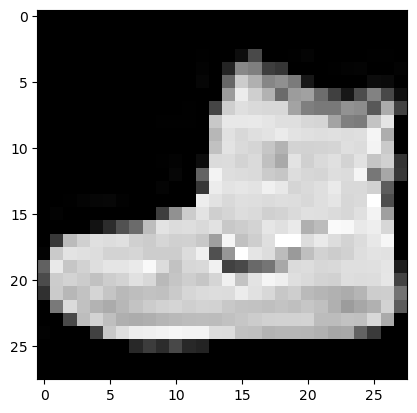

Label: 0


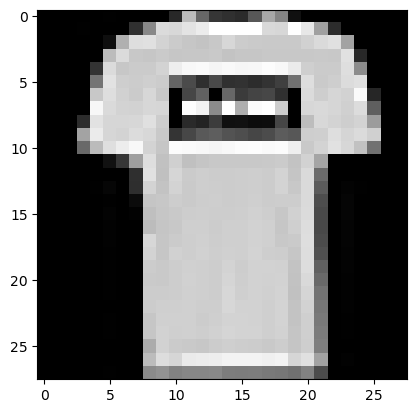

Label: 0


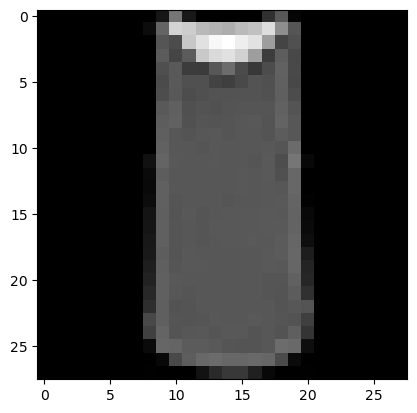

Label: 3


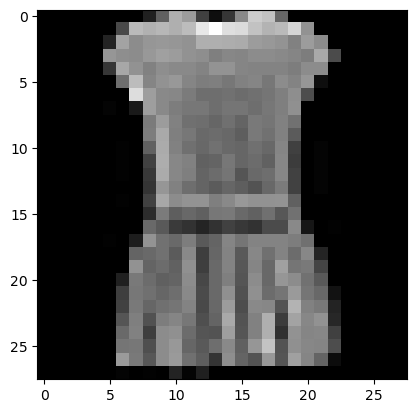

Label: 0


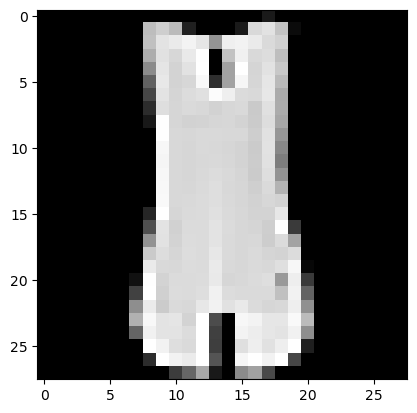

In [6]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
for i in range(len(train_features[:5])):
    
    img = train_features[i].squeeze()
    label = train_labels[i]
    print(f"Label: {label}")
    plt.imshow(img, cmap="gray")
    plt.show()
   

Feature batch shape: torch.Size([5, 1, 28, 28])
Labels batch shape: torch.Size([5])
Label: 9


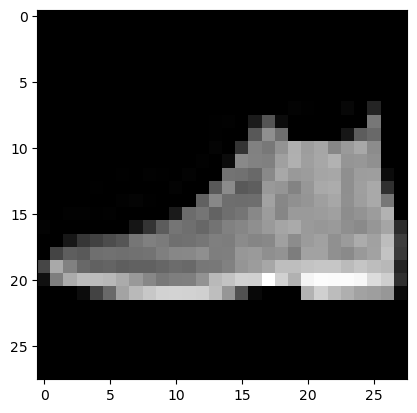

Label: 2


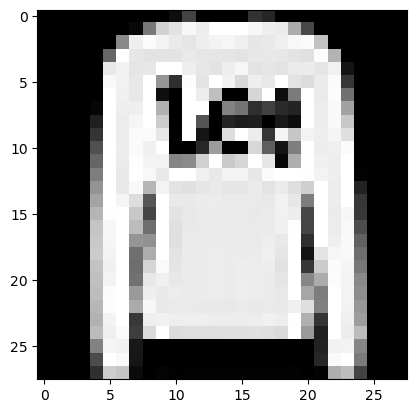

Label: 1


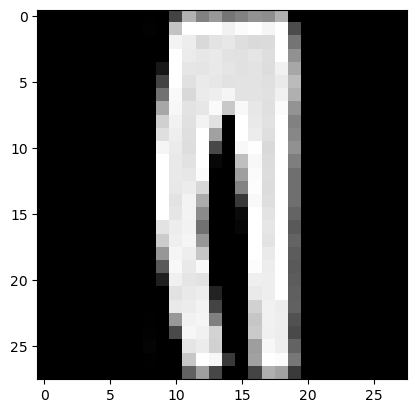

In [7]:
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
for i in range(len(test_features[:3])):
    
    img = test_features[i].squeeze()
    label = test_labels[i]
    print(f"Label: {label}")
    plt.imshow(img, cmap="gray")
    plt.show()

In [8]:
# Get cpu, gpu or mps device for training.
device = 'cuda'

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [9]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)

pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

predicted_class_index = y_pred.item()

predicted_class_label = labels_map[predicted_class_index]

for i in range(len(predicted_class_label)):
  print(f"Predicted class:{predicted_class_label}")

Predicted class:Shirt
Predicted class:Shirt
Predicted class:Shirt
Predicted class:Shirt
Predicted class:Shirt


In [10]:
# loss_fn =nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)

# def train(dataloader, model, loss_fn, optimizer):
#     size = len(dataloader.dataset)
#     model.train()
#     for batch, (X,y) in enumerate(dataloader):
#         X, y = X.to(device),y.to(device)

#         pred = model(X)
#         loss = loss_fn(pred,y)

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         if batch % 100 == 0:
#             loss,current = loss.item(),(batch+1)*len(X)
#             print(f"loss:{loss:>7f}[{current:>5d}/{size:>5d}]")
#             print(f"Predicted: {pred.argmax(1).cpu().numpy()}")
#             print(f"Labels: {y.cpu().numpy()}")

# def test(dataloader,model,loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     model.eval()
#     test_loss,correct = 0,0 
#     with torch.no_grad():
#         for X, y in dataloader:
#             X, y = X.to(device),y.to(device)
#             pred = model(X)
#             test_loss += loss_fn(pred,y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%,Avg loss: {test_loss:>8f}\n")

# epochs = 3
# for t in range(epochs):
#     print(f"Epoch {t+1}\n------------")
#     train(train_dataloader,model,loss_fn,optimizer)
#     test(test_dataloader, model, loss_fn)
# print("Done!")                    

In [11]:
torch.save(model.state_dict(),"model.pth")
print("Saved PyTorch Model State")

model.load_state_dict(torch.load('model.pth'))



Saved PyTorch Model State


<All keys matched successfully>

In [12]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))



classes = [
    "T Shirt",
    "Trousers",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",]

model.eval()

train_features = next(iter(train_dataloader))
for x,y in test_features:
    with torch.no_grad():
        x = x.to(device)
        pred = model(x)
        
        for i in len(range(test_features)):
            img = x[i].cpu().squeeze()
            label = y[i]
            predicted = classes[int(pred[i].argmax(0))]
            actual = classes[int(label)]
            plt.title(f'Predicted: "{predicted}", Actual: "{actual}"')
            plt.imshow(img, cmap ="gray")
            plt.show()



ValueError: not enough values to unpack (expected 2, got 1)